# MapReduce 2/2

Dans cette séance vous allez écrire une fonction générique permettant d'enchainer le flux de traitements du modèle MapReduce à partir de `mapper ` et `reducer` à fournir pour un problème donné. Vous utiliserez ensuite cette fonction pour implémenter le calcul des PageRank d'un graphe dans le cadre MapReduce. 

## Exercice #3 : fonction générique Map+Reduce

Le but de l'exercice est d'écrire une fonction `map_reduce()` permettant d'implémenter les étapes du modèle MapReduce de façon générique, en respectant les formats de données d'entrée et de sortie des différentes étapes (listes de tuples `(clé, valeur)`, voir le schéma du flux donné en cours).

La fonction prendra en entrée une liste de tuples `(clé d'entrée, valeur d'entrée)` correspondant aux données à traiter (paramètre `data`), une fonction définissant la partie Map (paramètre `mapper` ), et une fonction définissant la partie Reduce (paramètre `reducer`). Elle renverra une liste des tuples `(clé de sortie, valeur de sortie)` issus de l'étape Reduce finale.

Les fonctions définissant les paramètres `mapper` et `reducer` devront être adaptées au problème considéré et respecter les contraintes suivantes :
 - une fonction de type `mapper` prendra en paramètre un tuple `(clé d'entrée, valeur d'entrée)` et devra traiter cette entrée pour fournir une liste de tuples `(clé intermédiaire, valeur intermédiaire)`. *Remarque : à cette étape les clés intermédiaires ne sont pas nécessairement uniques et il peut même y avoir une seule clé intermédiaire pour toutes les valeurs intermédiaires (c'est le cas lorsque toutes les valeurs intermédiaires devront être agrégées en une valeur unique par le processus Reduce).*
 - une fonction de type `reducer` prendra en entrée un tuple `(clé intermédiaire, [liste de valeurs intermédiaires])` et devra traiter cette entrée pour fournir une liste de tuples `(clé de sortie, valeur de sortie)` répondant au problème considéré (cette liste de sortie peut éventuellement contenir un seul tuple `(clé de sortie, valeur de sortie)` pour un processus `reduce` donné).

Entre les étapes Map et Reduce, une fonction `partitioner()` (identique à tous les problèmes) sera chargée de rassembler les valeurs intermédiaires par clé intermédiaire : elle prendra en entré une liste des listes de tuples `(clé intermédiaire, valeur intermédiaire)` issues des processus Map et fournira en sortie une liste de tuples `(clé intermédiaire, [liste de valeurs intermédiaires])` qui serviront d'entrée aux processus Reduce.

Enfin, à l'issue des processus Reduce, les différentes listes de tuples `(clé de sortie, valeur de sortie)` seront rassemblées en une liste unique de tuples  `(clé de sortie, valeur de sortie)` qui sera retournée par la fonction `map_reduce()`.

  
**Question 3.1**

Implémenter les fonctions `map_reduce()` et `partitioner()` en respectant les étapes et contraintes énoncées ci-dessus. A une étape donnée, les traitements indépendants seront lancés grâce à la fonction `map()` de Python.


In [9]:
def partitioner(list_of_list):
    dic_partition = {}
    for l in list_of_list :
        for cle, val in l :
            dic_partition[cle] = [val] if cle not in dic_partition else dic_partition[cle]+[val]
    return list(dic_partition.items())

def map_reduce(data, mapper, reducer):
    
    list_of_list_inter = map(mapper, data)
    list_inter = partitioner(list_of_list_inter)
    list_red = map(reducer, list_inter)

    return [(cle, val) for l in list_red for (cle, val) in l]


**Question 3.2**

Refaire l'exercice de la similarité cosinus en utilisant maintenant la fonction `map_reduce()` générique, en définissant les fonctions `mapper` et `reducer` appropriées. On commencera par réfléchie au paires `(clé, valeur)` à adopter à chaque étape des traitements.

On rappelle qu'il y a trois traitements MapReduce distincts et indépendants pour le calcul de la similarité cosinus : deux pour le calcul des normes des deux vecteurs d'entrée, et un troisième pour le calcul du produit scalaire des deux vecteurs.

In [11]:
from math import sqrt
from functools import reduce
from operator import add

def mapper_norm(cle_val):
    cle, x = cle_val
    return [(1, x**2)]      # ici n'importe quelle clé en sortie du mapper convient

def mapper_prod(cle_val):
    cle, (x1, x2) = cle_val
    return [(1, x1*x2)]   # ici n'importe quelle clé en sortie du mapper convient 

def reducer_add(cle_val):
    cle, list_of_vals = cle_val
    return [(cle, reduce(add, list_of_vals))] 

def sim_cos_mr(v1, v2):
    data_mr_1 = enumerate(v1)
    data_mr_2 = enumerate(v2)
    data_mr_3 = enumerate(zip(v1, v2))

    norm1 = map_reduce(data_mr_1, mapper_norm, reducer_add)[0][1]
    norm2 = map_reduce(data_mr_2, mapper_norm, reducer_add)[0][1]
    prod = map_reduce(data_mr_3, mapper_prod, reducer_add)[0][1]

    return prod/sqrt(norm1*norm2)

ma_liste1 = list(range(1,10))
ma_liste2 = list(range(9,0,-1))

print(sim_cos_mr(ma_liste1, ma_liste2))

0.5789473684210527


**Question 3.3**

Refaire l'exercice du wordcount en utilisant maintenant la fonction `map_reduce()` générique et en définissant les fonctions `mapper` et `reducer` appropriées. On commencera par définir clairement quelles sont les clés et les valeurs à chaque étape du traitement : en entrée du `mapper`, en sortie du `mapper` (entrée du `partionner`), en sortie du `partionner` (entrée du `reducer`), et en sortie du `reducer`.

*Indication : la fonction `mapper` pourra fournir ici une liste de tuples `(clé intermédiaire, valeur intermédiaire)` avec comme clés intermédiaires ***tous*** les mots du fichier traité, et comme valeur intermédiaire associée à chaque mot la valeur `1` comme indicateur de présence du mot (il n'y a donc pas dans ce cas de combinaison des occurences au niveau du `mapper`, elle se fera globalement au niveau du `partitioner`).*

*Exemple de liste retournée : `[('modi', 1), ('ut', 1), ('amet', 1), ... ]`*

In [20]:
def tokenise(text):
    return text.lower().replace(".", " ").split()

data_in = [f"data/wordcount/sample{i}.txt" for i in range(3)]


def mapper_words(cle_val):
    filename = cle_val[1]
    with open(filename, 'rt', encoding='utf-8') as ifile:
        content = ifile.read()
    return [(w,1) for w in tokenise(content)]

def reducer_words(cle_val):
    return [(cle_val[0], len(cle_val[1]))]

data_mr_wc = enumerate(data_in)
print(sorted(map_reduce(data_mr_wc, mapper_words, reducer_words),key=lambda x:x[1], reverse=True))

[('est', 61), ('sit', 61), ('modi', 57), ('quisquam', 55), ('labore', 54), ('adipisci', 54), ('tempora', 53), ('dolor', 52), ('etincidunt', 52), ('neque', 52), ('numquam', 52), ('consectetur', 52), ('ut', 50), ('quiquia', 49), ('sed', 49), ('ipsum', 49), ('voluptatem', 47), ('amet', 47), ('dolore', 46), ('non', 46), ('quaerat', 46), ('eius', 45), ('velit', 44), ('porro', 42), ('dolorem', 40), ('magnam', 40), ('aliquam', 39)]


## Exercice #4 : PageRank en MapReduce

Le but de l'exercice est d'implémenter le calcul du PageRank dans le cadre du modèle de programmation MapReduce. Le cadre réparti et distribué offert par MapReduce est particulièrement utile dans ce contexte car il n'est pas rare que la taille du graphe analysé soit gigantesque et que par conséquent celui-ci ne puisse tenir en totalité en mémoire sur une machine unique. C'est le cas par exemple du graphe représentant le web ou un réseau social tel que Facebook. 

Dans ce cas des "morceaux" du graphe sont répartis sur plusieurs machines et les traitements relatifs à un sous-graphes sont localisés sur la machine qui le contient. Il est donc impossible pour un noeud donné de connaitre l'ensemble de ses prédécesseurs car cela suppose d'explorer le graphe dans sa totalité. Par contre il est souvent assez simple d'obtenir les successeurs d'un noeud : dans le cadre du web par exemple, il s'agit des liens contenus dans la page correspondant au noeud. Un noeud et la liste de ses successeurs sont donc enregistrés au même endroit.

La formule de base pour le calcul du PageRank d'un noeud $n$ d'un graphe vous est rappelée ci-dessous :
$$r_n = \frac{1 - \alpha}{N} + \alpha \sum_{p \rightarrow n} \frac{r_p}{d_p}$$

où $N$ est le nombre de noeuds dans le graphe, $p \rightarrow n$ désigne l'ensemble des prédécesseurs de $n$, $r_p$ est le PageRank du prédécesseur $p$, $d_p$ est le degré sortant de $p$ et $\alpha$ est le "damping factor" (valeurs typiques : 0.8 à 0.9).

L'ensemble des PageRank d'un graphe est estimé de façon itérative par l'algorithme *power iteration*. L'implémentation utilisant la formule de base ci-dessus vous est donnée dans la fonction `pagerank()` ci-dessous qui prend en premier paramètre un graphe Networkx. 

In [5]:
def pagerank(g, alpha=0.9, max_iter=100):  # est le graphe (networkx) analysé
    N = g.order()
    R = {node:1/N for node in g} # initialisation des pagerank
    
    for i in range(max_iter): # boucle d'itérations de l'algorithme power iteration
        # print(f'iteration : {i}')
        R_new={}
        for node in g:  # boucle sur les noeuds
            R_new[node] = 0
            for pred in g.predecessors(node): # boucle sur les prédécesseurs du noeud
                R_new[node] += R[pred]/g.out_degree(pred)
            R_new[node] = alpha*R_new[node]+(1-alpha)/N    # utilisation du damping factor alpha
        R = R_new  # mise à jour des pagerank
    return R

La formule de base et l'implémentation qui vous sont données ci-dessus font directement intervenir les prédécesseurs des noeuds. Dans le cadre MapReduce avec un graphe répartis, il va donc falloir remanier l'algorithme pour pouvoir distribuer les calculs en faisant intervenir les successeurs des noeuds et non les prédécesseurs.

Dans un premier temps vous aller visualiser le graphe étudié pour cet exercice et calculer ses Pagerank en utilisant l'implémentation de base afin d'avoir un résultat de référence. Bien entendu, pour pouvoir exécuter les programmes sur votre machine, le graphe utilisé est ici volaontairement de taille réduite.

### Travail préliminaire : visualisation du graphe et calcul des PageRank

**Question 4.1**

Le graphe vous est pour l'instant fourni en totalité dans le fichier `graph_web.txt` au format EdgeList (à placer dans un dossier `data/graphe/`). 

A l'aide du module NetworkX, charger et visualiser ce graphe.

['PAGE_01', 'PAGE_02', 'PAGE_03', 'PAGE_04', 'PAGE_05', 'PAGE_06', 'PAGE_07', 'PAGE_08', 'PAGE_09', 'PAGE_10', 'PAGE_11', 'PAGE_12', 'PAGE_13', 'PAGE_14', 'PAGE_15', 'PAGE_16', 'PAGE_17', 'PAGE_18', 'PAGE_19', 'PAGE_20', 'PAGE_21', 'PAGE_22', 'PAGE_23', 'PAGE_24', 'PAGE_25', 'PAGE_26', 'PAGE_27', 'PAGE_28', 'PAGE_29', 'PAGE_30', 'PAGE_31', 'PAGE_32', 'PAGE_33', 'PAGE_34', 'PAGE_35', 'PAGE_36', 'PAGE_37', 'PAGE_38', 'PAGE_39', 'PAGE_40', 'PAGE_41', 'PAGE_42', 'PAGE_43', 'PAGE_44', 'PAGE_45', 'PAGE_46', 'PAGE_47', 'PAGE_48', 'PAGE_49', 'PAGE_50', 'PAGE_51', 'PAGE_52', 'PAGE_53', 'PAGE_54', 'PAGE_55', 'PAGE_56', 'PAGE_57', 'PAGE_58', 'PAGE_59', 'PAGE_60', 'PAGE_61']


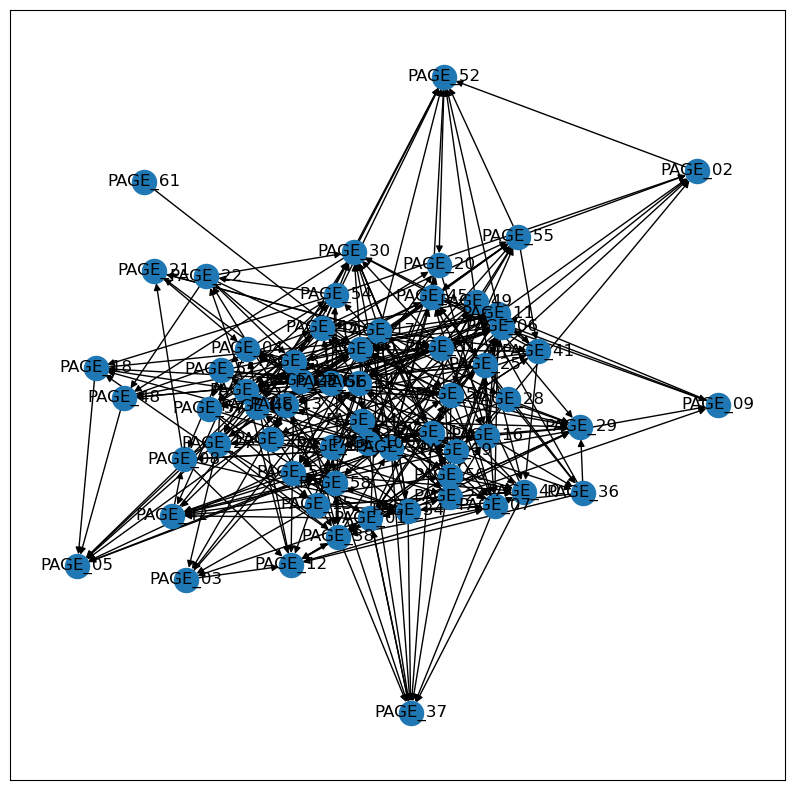

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.read_edgelist("data/graphe/graph_web.txt", create_using=nx.DiGraph)
print(sorted(G.nodes, key=lambda x: x[5:7]))
plt.figure(figsize=[10,10])
nx.draw_networkx(G)
plt.show()

**Question 4.2**

A l'aide de la fonction `pagerank()` fournie, calculer les PageRank des noeud de ce graphe et les afficher par ordre décroissant du PageRank.

In [6]:
print(sorted(pagerank(G).items(), key=lambda x : x[1], reverse=True))

[('PAGE_20', 0.04342658477602008), ('PAGE_01', 0.04044667012075506), ('PAGE_39', 0.03952780627022853), ('PAGE_52', 0.034988191958795364), ('PAGE_06', 0.03168467931210963), ('PAGE_10', 0.03161717374490561), ('PAGE_42', 0.031503130736661854), ('PAGE_37', 0.030291623025966004), ('PAGE_16', 0.029949364639107665), ('PAGE_38', 0.026799343482773068), ('PAGE_60', 0.023993733115415628), ('PAGE_30', 0.02371269371094365), ('PAGE_32', 0.023542172183212837), ('PAGE_24', 0.022146105697103104), ('PAGE_45', 0.0221218907761785), ('PAGE_40', 0.021700695902938768), ('PAGE_29', 0.021170379829435225), ('PAGE_05', 0.02100955612157885), ('PAGE_50', 0.020803198591317327), ('PAGE_12', 0.020683077671629795), ('PAGE_11', 0.019709550502423463), ('PAGE_25', 0.01769024440178124), ('PAGE_08', 0.016237111510039138), ('PAGE_55', 0.015981959325255028), ('PAGE_59', 0.015317132317295493), ('PAGE_13', 0.014362273071211618), ('PAGE_02', 0.014287383350138686), ('PAGE_44', 0.014187019308896397), ('PAGE_07', 0.014131066602452

**Question 4.3**

 Proposer une fonction `pagerank_succ()` avec les mêmes paramètres d'entrée que `pagerank()` et qui implémente l'algorihtme *power iteration* en utilisant uniquement l'information des successeurs des noeuds.

 Le principe ici est le suivant :
 - calculer pour chaque noeud $n$ la contribution qu'il apporte au PageRank de chacun de ses successeurs : $\frac{r_n}{d_n}$ où $r_n$ est le PageRank de $n$ et $d_n$ est le degré sortant de $n$
 - rassembler et additionner toutes les contributions associées à un même noeud pour obtenir le terme de somme dans la formule de base, puis appliquer le damping factor. Cas particulier : un noeud qui n'est le successeur d'aucun autre (et qui n'a donc aucune contribution associée) se verra attribuer un PageRank de $\frac{1 - \alpha}{N}$.
 
 Tester cette fonction sur le même graphe et vérifier qu'elle donne des résultats cohérents avec ceux de la première fonction. 

In [7]:
def pagerank_succ(g, alpha=0.9, max_iter=100):  # est le graphe (networkx) analysé
    N = g.order()
    R = {node:1/N for node in g} # initialisation des pagerank
    
    for i in range(max_iter): # boucle d'itérations de l'algorithme power iteration
        PR_terms= {}
        for n in g:  # boucle sur les noeuds
            pr_contrib = R[n]/g.out_degree(n)
            for s in g.successors(n): # boucle sur les successeurs du noeud
                PR_terms[s] = [pr_contrib] if s not in PR_terms else PR_terms[s]+[pr_contrib]
        R = {node:(1-alpha)/N if node not in PR_terms else alpha*sum(PR_terms[node])+(1-alpha)/N for node in g}  # mise à jour des PageRank pour l'itération suivante
    return R

print(sorted(pagerank_succ(G).items(), key=lambda x : x[1], reverse=True))

[('PAGE_20', 0.04342658477602007), ('PAGE_01', 0.04044667012075506), ('PAGE_39', 0.03952780627022853), ('PAGE_52', 0.034988191958795364), ('PAGE_06', 0.03168467931210964), ('PAGE_10', 0.03161717374490561), ('PAGE_42', 0.031503130736661854), ('PAGE_37', 0.030291623025965997), ('PAGE_16', 0.02994936463910766), ('PAGE_38', 0.026799343482773064), ('PAGE_60', 0.023993733115415628), ('PAGE_30', 0.02371269371094365), ('PAGE_32', 0.023542172183212837), ('PAGE_24', 0.022146105697103104), ('PAGE_45', 0.0221218907761785), ('PAGE_40', 0.02170069590293877), ('PAGE_29', 0.02117037982943522), ('PAGE_05', 0.02100955612157885), ('PAGE_50', 0.020803198591317327), ('PAGE_12', 0.02068307767162979), ('PAGE_11', 0.019709550502423463), ('PAGE_25', 0.017690244401781244), ('PAGE_08', 0.016237111510039138), ('PAGE_55', 0.01598195932525503), ('PAGE_59', 0.015317132317295493), ('PAGE_13', 0.014362273071211622), ('PAGE_02', 0.014287383350138686), ('PAGE_44', 0.014187019308896397), ('PAGE_07', 0.014131066602452998)

### Implémentation du PageRank dans le cadre MapReduce

Nous allons maintenant nous placer dans le cas où le graphe est réparti en plusieurs fichiers et où il ne peut pas être exploré dans sa totalité pour pouvoir trouver l'ensemble des prédécesseurs d'un noeud. Les différentes parties de ce graphe vous sont données dans les fichiers `graphe_web_0.txt` jusqu'à `graphe_web_5.txt`, sous forme de listes d'adjacence : chaque ligne donne la liste des successeurs d'un noeud du graphe, avec en première position le noeud considéré, suivi de ses successeurs, le tout séparé par des espaces. Un noeud n'apparait qu'une seule fois en première position dans l'ensemble des lignes rassemblées de tous les fichiers.

Le but ici est d'écrire une fonction `mr_pagerank()` permettant de calculer le PageRank des noeuds dans le cadre MapReduce en utilisant la fonction générique `map_reduce()` écrite précédemmment. La fonction `mr_pagerank()` prendra en entrée la liste des fichiers contenant le graphe réparti, le paramètre `alpha` représentant le damping factor choisi (valeur par défaut de 0.9) et le paramètre `max_iter` représentant le nombre d'itérations pour la convergence du PageRank (valeur par défaut de 100).

#### Analyse préliminaire

**Question 4.4**

Identifier les calculs indépendants sur des sous-patrties des données d'entrée qui pourront constituer la partie "Map" du traitement.

[*VOTRE REPONSE ICI*]()

*--> Calculs des contributions d'un noeud au PageRank de ses successeurs*

**Question 4.5**

Identifier les calculs d'agrégation qui constitueront la partie "Reduce" du traitement

[*VOTRE REPONSE ICI*]()

*--> Addition des contributions associées à chaque noeud et calcul final du PageRank du noeud*

**Question 4.6**

Identifier les paires `(clé , valeur)` à mettre en oeuvre à chaque niveau du flux de traitement MapReduce : en entrée et en sortie des `mapper`, en entrée et en sortie du `partitioner`, en entrée et en sortie du ou des `reducer`.

*Indication : veiller à ce qu'une paire `(clé, valeur)` contienne tous les éléments nécessaires au traitement suivant et adapter la `clé` et/ou la `valeur` en conséquence (une `clé` ou une `valeur` peut elle-même être un tuple contenant plusieurs éléments)*

[*VOTRE REPONSE ICI*]()

*-->*

- *entrée du `mapper` : tuple `(clé d'entrée, valeur d'entrée)`*
    - *--> un `mapper` par noeud*
    - *`clé d'entrée = (noeud, [liste des successeurs])`*
    - *`valeur d'entrée = PageRank du noeud`*
- *sortie du `mapper` : liste de tuples `(clé intermédiaire, valeur intermédiaire)`*
    - *`clé intermédiaire = successeur`*
    - *`valeur intermédiaire = contribution du prédécesseur`*
- *entrée du `partitioner` : liste de listes de tuples `(clé intermédiaire, valeur intermédiaire)`*
    - *`clé intermédiaire = noeud`*
    - *`valeur intermédiaire = contribution d'un des prédécesseurs du noeud`*
- *sortie du `partitioner` : liste de tuples `(clé intermédiaire, [liste de valeurs intermédiaires])`*
    - *`clé intermédiaire = noeud`*
    - *`valeurs intermédiaires = contributions des prédécesseurs du noeud`*
- *entrée du `reducer` : tuples `(clé intermédiaire, [liste de valeurs intermédiaires])`*
    - *--> un `reducer` par noeud*
    - *`clé intermédiaire = noeud`*
    - *`valeurs intermédiaires = contributions des prédécesseurs du noeud`*
- *sortie du `reducer` : tuples `(clé de sortie, valeur de sortie)`*
    - *`clé de sortie = noeud`*
    - *`valeurs de sortie = PageRank mis à jour du noeud`*

#### Mise en oeuvre du code

*Pour l'ensemble des questions suivantes, vous écrirez votre code dans la cellule qui suit les questions.* 

**Question 4.7**

Ecrire une fonction `get_nodes_and_successors()` qui prend en entrée un nom de fichier contenant une sous-partie du graphe et qui permet de récupérer un ensemble de noeuds associés chacun à la liste de ses successeurs. La fonction renverra une liste de tuples `(noeud, [liste des successeurs du noeud])`.

**Question 4.8**

Définir la fonction `mr_pagerank()` et y écrire une instruction qui permet de récupérer l'ensemble des noeuds du graphe associés à la liste de leurs successeurs en utilisant les fonctions `get_nodes_and_successors()` et `map()`.

**Question 4.9**

Ecrire la fonction `pr_mapper()` chargée d'effectuer les traitements de la partie Map.

**Question 4.10**

Ecrire la fonction `pr_reducer()` chargée d'effectuer les traitements de la partie Reduce.

**Question 4.11**

Compléter la fonction `mr_pagerank()`:
- calculer le nombre $N$ de noeuds dans le graphe
- initialiser les données d'entrée avec les PageRank initiaux de l'algorithme *power iteration*
- mettre en place la boucle d'itérations de l'algorithme *power iteration* qui utilisera la fonction `map_reduce()` pour calculer les valeurs mises à jour des PageRank.
- la fonction devra retourner une liste de tuples `(noeud, pagerank du noeud)` 

*Indication : il n'est pas possible de passer dynamiquement des valeurs au `mapper` et au `reducer` de la fonction `map_reduce()`, comme le paramètre `alpha` choisi par l'utilisateur ou le nombre $N$ de noeuds déterminé seulement après avoir parcouru les fichiers d'entrée. Ces paramètres sont pourtant nécessaires au calcul des PageRank. On pourra cependant utiliser une redéfinition dynamique de fonction comme dans l'exemple suivant :*

`my_pr_mappper = lambda x : pr_mapper(x, valeur1, valeur2)`

*où `valeur1` et `valeur2` sont des valeurs attribuées dynamiquement à des paramètres d'entrée de la fonction `pr_mapper`. C'est ensuite la référence `my_pr_mapper` qui sera passé en paramètre de la fonction `map_reduce()` (pour le paramètre `mapper`).*

**Question 4.12**

Tester la fonction `mr_pagerank()` en affichant les résultats par ordre décroissant des PageRank et comparer aux résultats obtenus avec les autres fonctions.

Le PageRank du noeud `PAGE_61` (correspondant à la dernière ligne du fichier `graph_web_5.txt`) apparait-il dans les résultats de votre fonction `mr_pagerank()` ?

Si ce n'est pas le cas, identifier le problème et y remédier.

*Indication : on pourra remarquer que*

$$r_n = \frac{1 - \alpha}{N} + \alpha \sum_{p \rightarrow n} \frac{r_p}{d_p} =  \alpha . \left( \sum_{p \rightarrow n} \frac{r_p}{d_p} +\frac{1 - \alpha}{\alpha.N} \right)$$

*On pourra donc ajouter par défaut une contribution $\frac{1 - \alpha}{\alpha.N}$ à tous les noeuds du graphe (y compris ceux sans prédécesseur) et faire ensuite une somme globale de toutes les contributions (à multiplier par $\alpha$ pour obtenir le PageRank final).*

In [25]:
def get_nodes_and_successors(filename):
    out_list = []
    with open(filename, 'rt', encoding="utf-8") as i_file:
        for line in i_file.readlines():
            line = line.strip().split()
            out_list.append((line[0], line[1:]))
    return out_list

def pr_mapper(my_tuple, alpha, N):
    (node, successors), pr = my_tuple
    nbs = len(successors)
    outlist = []
    outlist.append((node, (1 - alpha)/(alpha*N))) # pour traiter le cas des noeuds sans prédécesseur (question 4.12)
    contrib = pr/nbs
    for s in successors:
        outlist.append((s,contrib))
    return outlist

def pr_reducer(tuple, alpha):
    node, lst_pr = tuple
    pr = alpha*reduce(add, lst_pr)  # formule qui prend en compte le traitement spécial des noeuds sans prédécesseur (question 4.12)
    return [(node, pr)]


def mr_pagerank(data_mr_pr, alpha=0.9, max_iter=100):
    nodes_and_successors  = {x[0]:x[1] for l in map(get_nodes_and_successors, data_mr_pr) for x in l}
    N = len(nodes_and_successors)
    R = [((node, successors), 1/N) for node,successors in nodes_and_successors.items()]
    my_pr_mapper = lambda x : pr_mapper(x, alpha, N)
    my_pr_reducer = lambda x : pr_reducer(x, alpha)
    for i in range(max_iter):
        # print(f'iteration {i}')
        mr_res = map_reduce(R, my_pr_mapper, my_pr_reducer)
        R = [((node, nodes_and_successors[node]), pr) for node, pr in mr_res]

    return mr_res

data_mr_pr = [f"data/graphe/graph_web_{i}.txt" for i in range(6)]

In [23]:
print(sorted(mr_pagerank(data_mr_pr, alpha=0.9, max_iter=100), key=lambda x: x[1], reverse=True))


[('PAGE_20', 0.04346116887828716), ('PAGE_01', 0.0391462787405509), ('PAGE_39', 0.0390463310963811), ('PAGE_52', 0.035193324796622454), ('PAGE_06', 0.031756418867272346), ('PAGE_10', 0.0315103539770221), ('PAGE_42', 0.03105406773533447), ('PAGE_37', 0.030039196143005625), ('PAGE_16', 0.030010630905117245), ('PAGE_38', 0.026171898824851006), ('PAGE_30', 0.02491432166707788), ('PAGE_60', 0.023504873104732954), ('PAGE_32', 0.02307050137311689), ('PAGE_45', 0.022556432309048663), ('PAGE_24', 0.022539358051896705), ('PAGE_40', 0.02193519580216637), ('PAGE_50', 0.02122038794222955), ('PAGE_05', 0.021134902519340654), ('PAGE_29', 0.021131179420694066), ('PAGE_12', 0.02029759549429171), ('PAGE_11', 0.019706764840753767), ('PAGE_25', 0.017815381911471195), ('PAGE_07', 0.01740711718589139), ('PAGE_08', 0.016023690987011032), ('PAGE_55', 0.01577985366513824), ('PAGE_59', 0.015074086538607027), ('PAGE_44', 0.014365312585215999), ('PAGE_02', 0.014310711361963551), ('PAGE_13', 0.014237158193626177),

In [24]:
print(sorted(pagerank(G, alpha=0.9, max_iter=100).items(), key=lambda x: x[1], reverse=True))

[('PAGE_20', 0.04342658477602008), ('PAGE_01', 0.04044667012075506), ('PAGE_39', 0.03952780627022853), ('PAGE_52', 0.034988191958795364), ('PAGE_06', 0.03168467931210963), ('PAGE_10', 0.03161717374490561), ('PAGE_42', 0.031503130736661854), ('PAGE_37', 0.030291623025966004), ('PAGE_16', 0.029949364639107665), ('PAGE_38', 0.026799343482773068), ('PAGE_60', 0.023993733115415628), ('PAGE_30', 0.02371269371094365), ('PAGE_32', 0.023542172183212837), ('PAGE_24', 0.022146105697103104), ('PAGE_45', 0.0221218907761785), ('PAGE_40', 0.021700695902938768), ('PAGE_29', 0.021170379829435225), ('PAGE_05', 0.02100955612157885), ('PAGE_50', 0.020803198591317327), ('PAGE_12', 0.020683077671629795), ('PAGE_11', 0.019709550502423463), ('PAGE_25', 0.01769024440178124), ('PAGE_08', 0.016237111510039138), ('PAGE_55', 0.015981959325255028), ('PAGE_59', 0.015317132317295493), ('PAGE_13', 0.014362273071211618), ('PAGE_02', 0.014287383350138686), ('PAGE_44', 0.014187019308896397), ('PAGE_07', 0.014131066602452